# Matrix Generation

In [36]:
import numpy as np
from scipy.linalg import qr
import matplotlib.pyplot as plt


def generate_trial_matrix(n, class_type):
    M1 = np.random.rand(n, n)
    M2 = np.random.rand(n, n)
    Q1, _ = qr(M1)
    Q2, _ = qr(M2)

    if class_type == 1:
        singular_values = np.array([np.exp(-10 * (k - 1) / n) for k in range(1, n + 1)])
    elif class_type == 2:
        singular_values = np.array([(n - k + 1) / n for k in range(1, n + 1)])

    Σ = np.diag(singular_values)
    A = Q1 @ Σ @ Q2.T
    return A, singular_values


# Algorithm 1: Sampling-based SVD

In [37]:

def algorithm1(A, k, c):
    n = A.shape[1]
    col_norms = np.linalg.norm(A, axis=0)**2
    p = col_norms / np.sum(col_norms)

    selected_cols = []
    while len(selected_cols) < c:
        i = np.random.choice(n)
        u = np.random.uniform()
        if np.max(p) * u <= p[i]:
            selected_cols.append(i)

    A_hat = np.zeros((A.shape[0], c))
    for t, i in enumerate(selected_cols[:c]):
        A_hat[:, t] = A[:, i] / np.sqrt(c * p[i])

    ATA_hat = A_hat.T @ A_hat
    eigvals, eigvecs = np.linalg.eigh(ATA_hat)
    idx = np.argsort(eigvals)[::-1][:k]
    sigma = np.sqrt(eigvals[idx])
    y = eigvecs[:, idx]
    H = A_hat @ y / sigma
    return H, sigma

# Algorithm 2: Random Projection SVD

In [38]:

def algorithm2(A, k):
    n = A.shape[1]
    x = np.random.randn(n, k)
    Y = A @ x
    Q, _ = qr(Y, mode='economic')
    B = Q.T @ A
    U_hat, sigma, _ = np.linalg.svd(B, full_matrices=False)
    U_hat = U_hat[:, :k]
    sigma = sigma[:k]
    U = Q @ U_hat
    return U, sigma


# Error Calculation

In [39]:

def compute_errors(A, U_hat, sigma_hat, sigma_true, k):
    E1 = np.sum((sigma_hat[:k] - sigma_true[:k])**2) / np.sum(sigma_true[:k]**2)
    true_proj_error = np.sum(sigma_true[k:]**2)
    approx_proj = U_hat @ U_hat.T @ A
    approx_proj_error = np.linalg.norm(A - approx_proj, ord='fro')**2
    E2 = np.abs(approx_proj_error / true_proj_error - 1) if true_proj_error != 0 else 0.0
    return E1, E2



# Main Experiment


In [40]:

n_values = [100, 200, 400, 800,1600]
results = {1: {'algo1_e1': [], 'algo1_e2': [], 'algo2_e1': [], 'algo2_e2': []},
           2: {'algo1_e1': [], 'algo1_e2': [], 'algo2_e1': [], 'algo2_e2': []}}

for class_type in [1, 2]:
    for n in n_values:
        k_values = [
            int(np.round(np.log2(n))),
            int(np.round(np.log2(n)**2)),
            int(np.round(n/10))
        ]

        algo1_e1_results = []
        algo1_e2_results = []
        algo2_e1_results = []
        algo2_e2_results = []

        for k in k_values:
            c = 2 * k

            e1_alg1, e2_alg1, e1_alg2, e2_alg2 = [], [], [], []
            for _ in range(3):  # Reduced runs for performance
                A, sigma_true = generate_trial_matrix(n, class_type)

                # Algorithm 1
                H, sigma_hat_alg1 = algorithm1(A, k, c)
                e1, e2 = compute_errors(A, H, sigma_hat_alg1, sigma_true, k)
                e1_alg1.append(e1)
                e2_alg1.append(e2)

                # Algorithm 2
                U_hat, sigma_hat_alg2 = algorithm2(A, k)
                e1, e2 = compute_errors(A, U_hat, sigma_hat_alg2, sigma_true, k)
                e1_alg2.append(e1)
                e2_alg2.append(e2)

            algo1_e1_results.append(np.mean(e1_alg1))
            algo1_e2_results.append(np.mean(e2_alg1))
            algo2_e1_results.append(np.mean(e1_alg2))
            algo2_e2_results.append(np.mean(e2_alg2))

        results[class_type]['algo1_e1'].append(algo1_e1_results)
        results[class_type]['algo1_e2'].append(algo1_e2_results)
        results[class_type]['algo2_e1'].append(algo2_e1_results)
        results[class_type]['algo2_e2'].append(algo2_e2_results)


# Plotting (8 Plots)


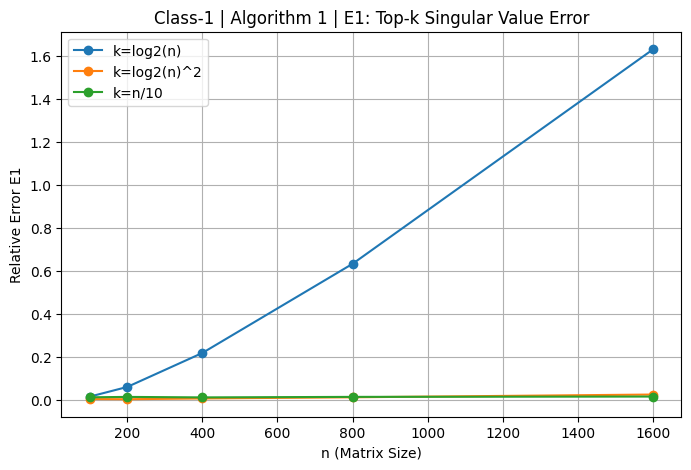

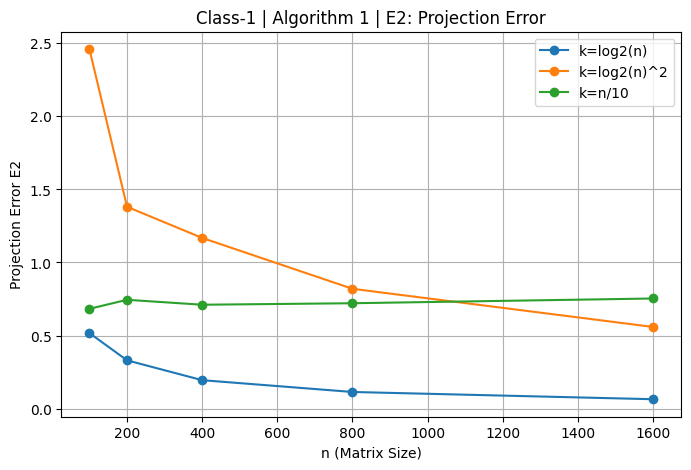

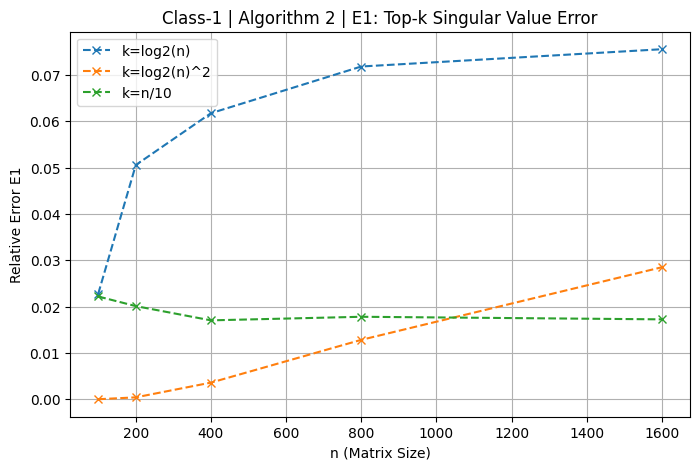

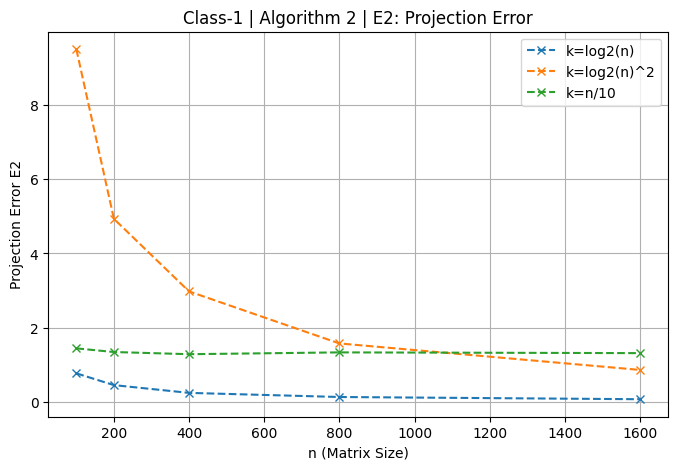

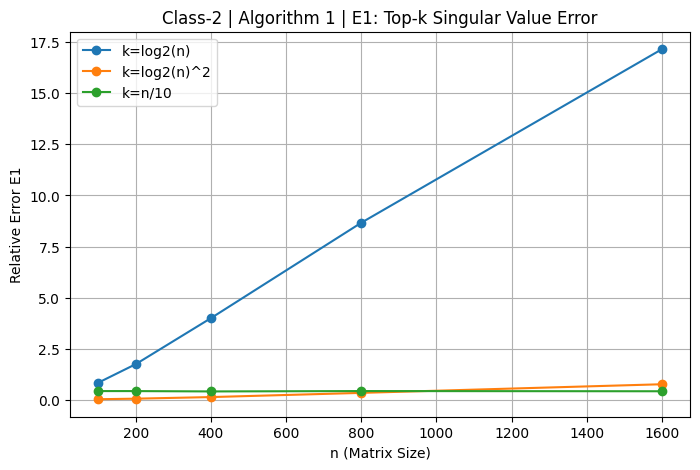

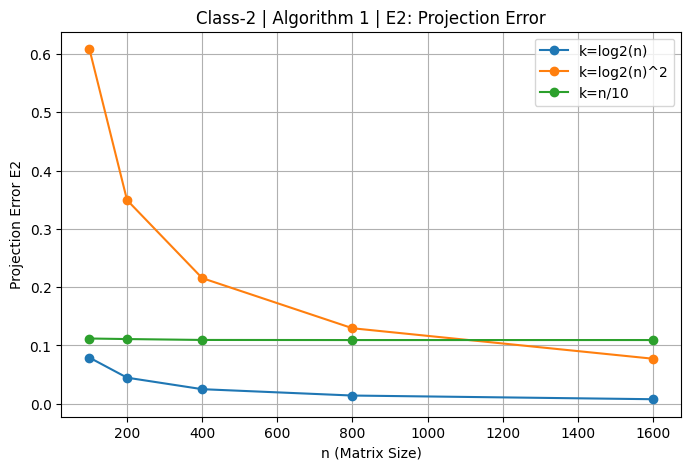

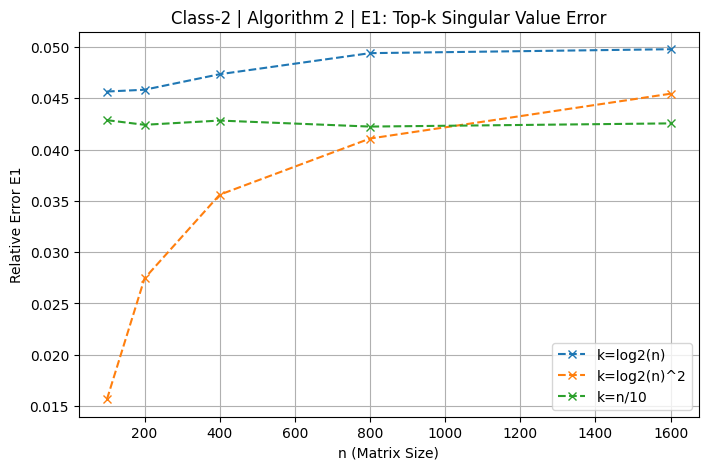

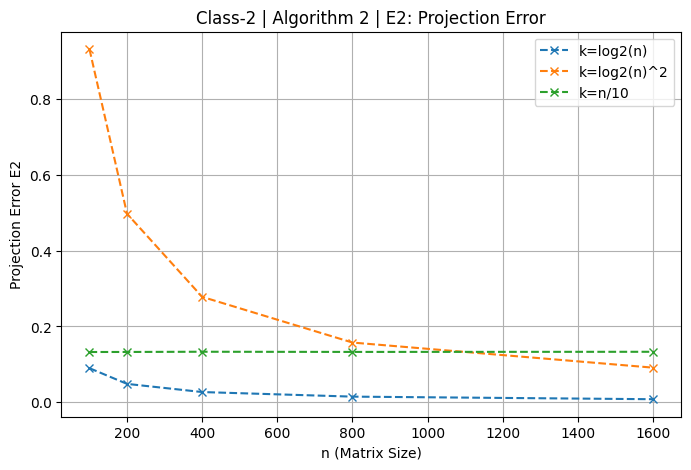

In [41]:
labels = ['log2(n)', 'log2(n)^2', 'n/10']

for class_type in [1, 2]:
    # Algorithm 1 - E1
    plt.figure(figsize=(8, 5))
    for i in range(3):
        y = [results[class_type]['algo1_e1'][j][i] for j in range(len(n_values))]
        plt.plot(n_values, y, marker='o', label=f'k={labels[i]}')
    plt.xlabel("n (Matrix Size)")
    plt.ylabel("Relative Error E1")
    plt.title(f"Class-{class_type} | Algorithm 1 | E1: Top-k Singular Value Error")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Algorithm 1 - E2
    plt.figure(figsize=(8, 5))
    for i in range(3):
        y = [results[class_type]['algo1_e2'][j][i] for j in range(len(n_values))]
        plt.plot(n_values, y, marker='o', label=f'k={labels[i]}')
    plt.xlabel("n (Matrix Size)")
    plt.ylabel("Projection Error E2")
    plt.title(f"Class-{class_type} | Algorithm 1 | E2: Projection Error")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Algorithm 2 - E1
    plt.figure(figsize=(8, 5))
    for i in range(3):
        y = [results[class_type]['algo2_e1'][j][i] for j in range(len(n_values))]
        plt.plot(n_values, y, marker='x', linestyle='--', label=f'k={labels[i]}')
    plt.xlabel("n (Matrix Size)")
    plt.ylabel("Relative Error E1")
    plt.title(f"Class-{class_type} | Algorithm 2 | E1: Top-k Singular Value Error")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Algorithm 2 - E2
    plt.figure(figsize=(8, 5))
    for i in range(3):
        y = [results[class_type]['algo2_e2'][j][i] for j in range(len(n_values))]
        plt.plot(n_values, y, marker='x', linestyle='--', label=f'k={labels[i]}')
    plt.xlabel("n (Matrix Size)")
    plt.ylabel("Projection Error E2")
    plt.title(f"Class-{class_type} | Algorithm 2 | E2: Projection Error")
    plt.legend()
    plt.grid(True)
    plt.show()







